# k-Nearest Neighbors (kNN)

In [1]:
import pandas as pd
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier

## Example: Riding Mowers

A riding-mower manufacturer would like to find a way of classifying families in a city into those likely to purchase a riding mower and those not likely to buy one. A pilot random sample is undertaken of 12 owners and 12 nonowners in the city. The data are in `RidingMowers.csv`. 

We first partition the data into training data (14 households) and validation data (10 households). Obviously, this dataset is too small for partitioning, which can result in unstable results. We use this partitioning only for illustration purposes.

Next, consider a new household with $60,000 income and lot size 20,000 ft2. Among the households in the training set, the one closest to the new household (in Euclidean distance after normalizing income and lot size) is household 4, with $61,500 income and lot size 20,800 ft2. 

In [2]:
mower_df = pd.read_csv('data/RidingMowers.csv')
mower_df['Number'] = mower_df.index + 1
mower_df.head(9)

,Income,Lot_Size,Ownership,Number
0,60.0,18.4,Owner,1
1,85.5,16.8,Owner,2
2,64.8,21.6,Owner,3
3,61.5,20.8,Owner,4
4,87.0,23.6,Owner,5
5,110.1,19.2,Owner,6
6,108.0,17.6,Owner,7
7,82.8,22.4,Owner,8
8,69.0,20.0,Owner,9


In [3]:
trainData, validData = train_test_split(mower_df, test_size=0.4, random_state=100)
print(trainData.shape, validData.shape)
newHousehold = pd.DataFrame([{'Income': 60, 'Lot_Size': 20}])
newHousehold

(14, 4) (10, 4)


,Income,Lot_Size
0,60,20


### Visualization

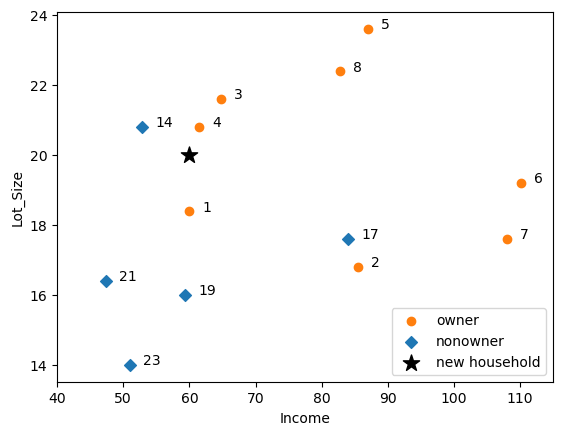

In [4]:
# OO-style plotting
fig, ax = plt.subplots() 

subset = trainData.loc[trainData['Ownership']=='Owner']
ax.scatter(subset.Income, subset.Lot_Size, marker='o', label='owner', color='C1')

subset = trainData.loc[trainData['Ownership']=='Nonowner']
ax.scatter(subset.Income, subset.Lot_Size, marker='D', label='nonowner', color='C0')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*', 
           label='new household', color='black', s=150)

plt.xlabel('Income')  # set x-axis label
plt.ylabel('Lot_Size')  # set y-axis label
for _, row in trainData.iterrows():
    ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))
    
handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

As shown above, if we use a 1-NN classifier, we would classify the new household as an owner, like household 4.

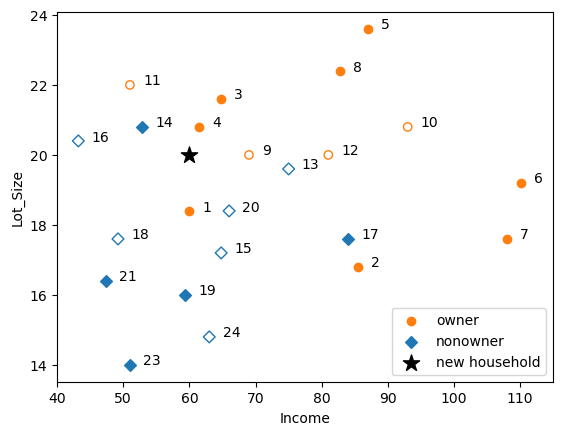

In [5]:
def plotDataset(ax, data, showLabel=True, **kwargs):
    subset = data.loc[data['Ownership']=='Owner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='o', 
               label='owner' if showLabel else None, color='C1', **kwargs)

    subset = data.loc[data['Ownership']=='Nonowner']
    ax.scatter(subset.Income, subset.Lot_Size, marker='D', 
               label='nonowner' if showLabel else None, color='C0', **kwargs)

    plt.xlabel('Income')  # set x-axis label
    plt.ylabel('Lot_Size')  # set y-axis label
    for _, row in data.iterrows():
        ax.annotate(row.Number, (row.Income + 2, row.Lot_Size))

fig, ax = plt.subplots()

plotDataset(ax, trainData)
plotDataset(ax, validData, showLabel=False, facecolors='none')

ax.scatter(newHousehold.Income, newHousehold.Lot_Size, marker='*', 
           label='new household', color='black', s=150)

plt.xlabel('Income')  # set x-axis label
plt.ylabel('Lot_Size')  # set y-axis label
    
handles, labels = ax.get_legend_handles_labels()
ax.set_xlim(40, 115)
ax.legend(handles, labels, loc=4)

plt.show()

If we use $k = 3$, the three nearest households are 4, 14, and 1, as can be seen visually in the scatter plot, and as computed by the software. Two of these neighbors are owners of riding mowers, and one is a nonowner. The majority vote is therefore owner, and the new household would be classified as an owner.

Initialize normalized training, validation, and complete data frames. Use the training data to learn the transformation.

In [6]:
scaler = preprocessing.StandardScaler()
scaler.fit(trainData[['Income', 'Lot_Size']])  
# note that scaler is only fitted to the training data
# the same scaling is then applied to the validation data

# transform the full dataset
mowerNorm = pd.concat([pd.DataFrame(scaler.transform(mower_df[['Income', 'Lot_Size']]), 
                                    columns=['zIncome', 'zLot_Size']),
                       mower_df[['Ownership', 'Number']]], axis=1)
trainNorm = mowerNorm.iloc[trainData.index]
validNorm = mowerNorm.iloc[validData.index]
newHouseholdNorm = pd.DataFrame(scaler.transform(newHousehold), 
                                columns=['zIncome', 'zLot_Size'])

### Apply $k$-nearest neighbour

The `NearestNeighbors` class from the `sklearn.neighbors` module is commonly used for finding the nearest neighbors of a data point in a dataset.

In [7]:
knn = NearestNeighbors(n_neighbors=3)
knn.fit(trainNorm[['zIncome', 'zLot_Size']])
distances, indices = knn.kneighbors(newHouseholdNorm)
print(trainNorm.iloc[indices[0], :])  # indices is a list of lists, we are only interested in the first element

     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


In [8]:
knn = NearestNeighbors(n_neighbors=1)
knn.fit(trainNorm[['zIncome', 'zLot_Size']])
distances, indices = knn.kneighbors(newHouseholdNorm)
print(trainNorm.iloc[indices[0], :])

    zIncome  zLot_Size Ownership  Number
3 -0.409776   0.743358     Owner       4


### Choosing $k$

The advantage of choosing $k > 1$ is that higher values of $k$ provide smoothing that reduces the risk of overfitting due to noise in the training data. Generally speaking, if $k$ is too low, we may be fitting to the noise in the data. However, if $k$ is too high, we will miss out on the method’s ability to capture the local structure in the data, one of its main advantages. In the extreme, $k = n =$
the number of records in the training dataset. In that case, we simply assign all records to the majority class in the training data, irrespective of the values of $(x_1, x_2, \ldots, x_p)$, which coincides with the naive rule! This is clearly a case of oversmoothing in the absence of useful information in the predictors about the class membership. In other words, we want to balance between overfitting
to the predictor information and ignoring this information completely. A balanced choice greatly depends on the nature of the data. The more complex and irregular the structure of the data, the lower the optimum value of $k$. Typically, values of $k$ fall in the range of 1--20. We will use odd numbers to avoid ties.

**So how is $k$ chosen?** Answer: We choose the $k$ with the best classification performance. We use the training data to classify the records in the validation data, then compute error rates for various choices of $k$. For our example, if we choose $k = 1$, we will classify in a way that is very sensitive to the local characteristics of the training data. On the other hand, if we choose a large value of $k$, such as $k = 14$, we would simply predict the most frequent class in the dataset in all cases. This is a very stable prediction but it completely ignores the information in the predictors. To find a balance, we examine the accuracy (of predictions in the validation set) that results from different choices of $k$ between 1 and 14. For an even number $k$, if there is a tie in classifying a household, the tie is broken randomly. We would choose $k = 4$, which maximizes our accuracy in the validation set. Note, however, that now the validation set is used as part of the training process (to set $k$) and does not reflect a true holdout set as before. Ideally, we would want a third test set to evaluate the performance of the method on data that it did not see.


Once $k$ is chosen, we rerun the algorithm on the combined training and testing sets in order to generate classifications of new records. An example is shown below, where the four nearest neighbors are used to classify the new household.

Initialize a data frame with two columns: `k` and `accuracy`

In [9]:
train_X = trainNorm[['zIncome', 'zLot_Size']]
train_y = trainNorm['Ownership']
valid_X = validNorm[['zIncome', 'zLot_Size']]
valid_y = validNorm['Ownership']

# train a classifier for different values of k
results = []
for k in range(1, 15):
    knn = KNeighborsClassifier(n_neighbors=k).fit(train_X, train_y)
    results.append({
        'k': k,
        'accuracy': accuracy_score(valid_y, knn.predict(valid_X))
    })

# convert results to a pandas data frame
results = pd.DataFrame(results)
print(results)

     k  accuracy
0    1       0.6
1    2       0.7
2    3       0.8
3    4       0.9
4    5       0.7
5    6       0.9
6    7       0.9
7    8       0.9
8    9       0.9
9   10       0.8
10  11       0.8
11  12       0.9
12  13       0.4
13  14       0.4


In [10]:
# retrain with full dataset
mower_X = mowerNorm[['zIncome', 'zLot_Size']]
mower_y = mowerNorm['Ownership']
knn = KNeighborsClassifier(n_neighbors=4).fit(mower_X, mower_y)
distances, indices = knn.kneighbors(newHouseholdNorm)
print(knn.predict(newHouseholdNorm))
print('Distances',distances)
print('Indices', indices)
print(mowerNorm.iloc[indices[0], :])

['Owner']
Distances [[0.31358009 0.40880312 0.44793643 0.61217726]]
Indices [[ 3  8 13  0]]
     zIncome  zLot_Size Ownership  Number
3  -0.409776   0.743358     Owner       4
8  -0.069107   0.437269     Owner       9
13 -0.804953   0.743358  Nonowner      14
0  -0.477910  -0.174908     Owner       1


### Converting categorical variables to binary dummies

It usually does not make sense to calculate Euclidean distance between two nonnumeric categories (e.g., cookbooks and maps, in a bookstore). Therefore, before kNN can be applied, categorical variables must be converted to binary dummies. 

In contrast to the situation with statistical models such as regression, all $m$ binaries should be created and used with kNN. While mathematically this is redundant, since $m-1$ dummies contain the same information asmdummies, this redundant information **does not create the multicollinearity problems that it does for linear models**. Moreover, in kNN the use of $m-1$ dummies can yield different classifications than the use of $m$ dummies, and lead to an imbalance in the contribution of the different categories to the model.